# Cuaderno 03: Entrenamiento de la Vía Visual (Grafema -> Secuencia de Embeddings)

**Objetivo:** Entrenar un modelo capaz de predecir la secuencia completa de embeddings auditivos (`wav2vec2`) a partir de una única imagen de su grafema correspondiente (letra de EMNIST).

**Flujo de Trabajo:**
1.  **Instalación y Configuración**: Instalar `cornet` y definir los parámetros globales.
2.  **Preparación de Datos**: Crear un `Dataset` que empareje cada imagen de EMNIST con su secuencia de embedding auditivo correspondiente. Esto incluye una función `collate_fn` para manejar el padding.
3.  **Definición del Modelo**: Construir el modelo híbrido `CORNet-Z (congelado) + Decodificador LSTM (entrenable)`.
4.  **Bucle Principal de Entrenamiento**: Entrenar y evaluar el modelo para español e inglés en una sola ejecución.
5.  **Análisis Comparativo**: Visualizar la pérdida y la similitud coseno para comparar el rendimiento entre idiomas.

In [1]:
%pip install cornet --quiet
%gui qt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
import torchvision.transforms as transforms
from PIL import Image
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from cornet.cornet_z import CORnet_Z
from tqdm.auto import tqdm
import os
import torch.nn.functional as F

# --- Parámetros Globales ---
LANGUAGES = ['es', 'en']
MODEL_ARCHITECTURE = "cornetZ_lstm_decoder_v1"
EPOCHS = 30
BATCH_SIZE = 32
LEARNING_RATE = 0.001
VALIDATION_SPLIT = 0.2

# --- Rutas ---
project_root = Path.cwd().parent
model_dir = project_root / "results/trained_models"
figure_dir = project_root / "results/figures"
results_dir = project_root / "results/tables"
model_dir.mkdir(parents=True, exist_ok=True)
figure_dir.mkdir(parents=True, exist_ok=True)
results_dir.mkdir(parents=True, exist_ok=True)

# Diccionario para almacenar todos los resultados
results_visual = {}

## Paso 1: Definición del Dataset y el Modelo

Definimos las clases para nuestro `Dataset` personalizado y el modelo `VisualToAuditoryModel`.

-   **`GraphemeDataset`**: Se encarga de cargar una imagen de una letra y su correspondiente secuencia de embedding auditivo. Filtra para usar solo los grafemas que existen en ambos dominios (visual y auditivo).
-   **`VisualToAuditoryModel`**: Contiene la arquitectura CORNet-Z + Decodificador LSTM.

In [ ]:
# --- Importaciones Necesarias para esta Celda ---
from collections import OrderedDict
from torch.utils.data import Dataset
from PIL import Image
import torch
import torch.nn as nn
import numpy as np
# La clase CORnet_Z está en el módulo cornet_z.py
from cornet.cornet_z import CORnet_Z

# --- Definición del Dataset (sin cambios) ---
class GraphemeDataset(Dataset):
    def __init__(self, image_dir, embedding_dir, transform=None):
        self.transform = transform
        self.embedding_dir = embedding_dir
        image_graphemes = {p.parent.name for p in image_dir.glob("*/*.png")}
        embedding_graphemes = {p.stem for p in embedding_dir.glob("*.npy")}
        common_graphemes = sorted(list(image_graphemes.intersection(embedding_graphemes)))
        self.image_paths = []
        for grapheme in common_graphemes:
            self.image_paths.extend(list((image_dir / grapheme).glob("*.png")))
        print(f"Dataset creado con {len(self.image_paths)} imágenes de {len(common_graphemes)} grafemas comunes.")
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = img_path.parent.name
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        embedding_path = self.embedding_dir / f"{label}.npy"
        embedding = torch.tensor(np.load(embedding_path), dtype=torch.float32)
        return image, embedding, label

# --- Definición del Modelo (con la carga de CORNet corregida) ---
class VisualToAuditoryModel(nn.Module):
    def __init__(self, target_embedding_dim=1024, lstm_hidden_dim=512, dropout=0.3):
        super().__init__()
        
        # 1. Creamos una instancia del modelo CORnet-Z
        self.cornet = CORnet_Z()
        
        # 2. Definimos la URL de los pesos pre-entrenados
        url = 'https://s3.amazonaws.com/cornet-models/cornet_z-5c427c9c.pth'
        
        # 3. Cargamos los pesos desde la URL
        ckpt_data = torch.hub.load_state_dict_from_url(url, map_location="cpu")
        original_state_dict = ckpt_data['state_dict']

        # --- CORRECCIÓN DEFINITIVA: Limpiamos el prefijo 'module.' de las claves ---
        new_state_dict = OrderedDict()
        for k, v in original_state_dict.items():
            name = k[7:] if k.startswith('module.') else k # elimina el prefijo `module.`
            new_state_dict[name] = v
        # --------------------------------------------------------------------------

        # 4. Cargamos el state_dict ya limpio en nuestro modelo
        self.cornet.load_state_dict(new_state_dict)
        
        cornet_output_dim = self.cornet.decoder.linear.in_features
        self.cornet.decoder.linear = nn.Identity()
        for param in self.cornet.parameters():
            param.requires_grad = False
            
        self.projector = nn.Sequential(nn.Linear(cornet_output_dim, lstm_hidden_dim), nn.BatchNorm1d(lstm_hidden_dim), nn.ReLU(), nn.Dropout(dropout))
        self.decoder_lstm = nn.LSTM(input_size=lstm_hidden_dim, hidden_size=lstm_hidden_dim, num_layers=2, batch_first=True, dropout=dropout)
        self.output_layer = nn.Linear(lstm_hidden_dim, target_embedding_dim)

    def forward(self, image, target_sequence):
        seq_len = target_sequence.shape[1]
        cornet_features = self.cornet(image)
        projected_features = self.projector(cornet_features)
        h0 = projected_features.unsqueeze(0).repeat(self.decoder_lstm.num_layers, 1, 1)
        c0 = torch.zeros_like(h0)
        decoder_input = projected_features.unsqueeze(1).repeat(1, seq_len, 1)
        lstm_output, _ = self.decoder_lstm(decoder_input, (h0, c0))
        predicted_sequence = self.output_layer(lstm_output)
        return predicted_sequence

## Paso 2: Bucle Principal de Procesamiento y Entrenamiento

Este bucle itera sobre cada idioma para entrenar y evaluar el modelo `VisualToAuditoryModel`. Incluye una `collate_fn` personalizada para manejar el padding tanto de las imágenes (si fuera necesario) como de las secuencias de embeddings.

In [5]:
# Definir las transformaciones para las imágenes de EMNIST
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# --- CORRECCIÓN: Cambiamos la función de pérdida a MSELoss ---
loss_fn = nn.MSELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_fn_visual(batch):
    images = [item[0] for item in batch]
    embeddings = [item[1] for item in batch]
    images_tensor = torch.stack(images)
    padded_embeddings = pad_sequence(embeddings, batch_first=True, padding_value=0.0)
    return images_tensor, padded_embeddings

for lang in LANGUAGES:
    print(f"\n{'='*20} PROCESANDO IDIOMA: {lang.upper()} {'='*20}")
    
    # --- 1. Crear Datasets y DataLoaders ---
    image_dir = project_root / f"data/02_processed/grapheme_images/{lang}"
    embedding_dir = project_root / f"data/02_processed/wav2vec2_embeddings/{lang}"
    
    full_dataset = GraphemeDataset(image_dir, embedding_dir, transform=transform)
    
    val_size = int(VALIDATION_SPLIT * len(full_dataset))
    train_size = len(full_dataset) - val_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn_visual)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn_visual)

    # --- 2. Instanciar y Entrenar el Modelo ---
    model = VisualToAuditoryModel().to(device)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    history = {'train_loss': [], 'val_loss': [], 'val_euclidean_dist': []}

    print(f"Entrenando modelo para '{lang}' con {len(train_dataset)} imágenes de entrenamiento...")
    for epoch in tqdm(range(EPOCHS), desc=f'Training {lang.upper()}'):
        model.train()
        running_loss = 0.0
        for images, target_embeddings in train_loader:
            images, target_embeddings = images.to(device), target_embeddings.to(device)
            optimizer.zero_grad()
            predicted_embeddings = model(images, target_embeddings)
            
            # --- CORRECCIÓN: Se elimina el tercer argumento de la función de pérdida ---
            loss = loss_fn(
                predicted_embeddings.flatten(0, 1),
                target_embeddings.flatten(0, 1)
            )
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        history['train_loss'].append(running_loss / len(train_loader))

        # Validación
        model.eval()
        running_val_loss = 0.0
        running_distance = 0.0
        with torch.no_grad():
            for images, target_embeddings in val_loader:
                images, target_embeddings = images.to(device), target_embeddings.to(device)
                predicted_embeddings = model(images, target_embeddings)
                
                # --- CORRECCIÓN: Se elimina el tercer argumento también aquí ---
                loss = loss_fn(
                    predicted_embeddings.flatten(0, 1),
                    target_embeddings.flatten(0, 1)
                )
                running_val_loss += loss.item()
                
                dist = F.pairwise_distance(
                    predicted_embeddings.mean(dim=1),
                    target_embeddings.mean(dim=1),
                    p=2
                ).mean()
                running_distance += dist.item()

        history['val_loss'].append(running_val_loss / len(val_loader))
        history['val_euclidean_dist'].append(running_distance / len(val_loader))
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{EPOCHS}], Train Loss: {history['train_loss'][-1]:.4f}, Val Loss: {history['val_loss'][-1]:.4f}, Val Euclidean Dist: {history['val_euclidean_dist'][-1]:.4f}")

    results_visual[lang] = {'history': history, 'model': model, 'val_dataset': val_dataset}
    
print(f"\n{'='*20} PROCESO COMPLETADO {'='*20}")


==================== PROCESANDO IDIOMA: ES ====================
Dataset creado con 1150 imágenes de 23 grafemas comunes.
Entrenando modelo para 'es' con 920 imágenes de entrenamiento...


Training ES:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch [10/30], Train Loss: 0.0013, Val Loss: 0.0016, Val Euclidean Dist: 0.2968
Epoch [20/30], Train Loss: 0.0010, Val Loss: 0.0015, Val Euclidean Dist: 0.2965
Epoch [30/30], Train Loss: 0.0011, Val Loss: 0.0015, Val Euclidean Dist: 0.3453

==================== PROCESANDO IDIOMA: EN ====================
Dataset creado con 1200 imágenes de 24 grafemas comunes.
Entrenando modelo para 'en' con 960 imágenes de entrenamiento...


Training EN:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch [10/30], Train Loss: 0.0018, Val Loss: 0.0021, Val Euclidean Dist: 0.3741
Epoch [20/30], Train Loss: 0.0015, Val Loss: 0.0018, Val Euclidean Dist: 0.2716
Epoch [30/30], Train Loss: 0.0014, Val Loss: 0.0016, Val Euclidean Dist: 0.1951

==================== PROCESO COMPLETADO ====================


## Paso 3: Visualizaciones Comparativas y Guardado

Una vez entrenados los modelos, comparamos sus curvas de aprendizaje y su rendimiento final en la métrica de similitud coseno.

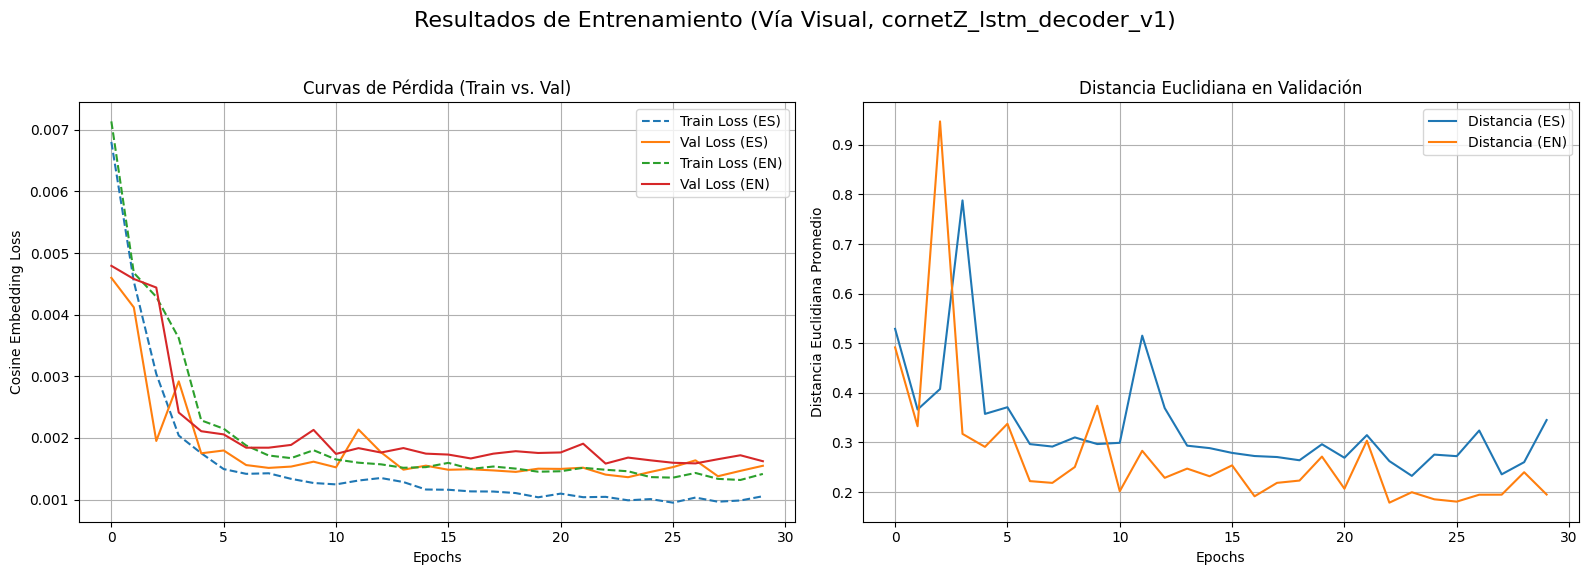

Curvas de aprendizaje guardadas en: /home/daniel/Proyectos/phonological-awareness/results/figures/comparative_visual_cornetZ_lstm_decoder_v1_learning_curves.png
Modelo para 'es' guardado en: /home/daniel/Proyectos/phonological-awareness/results/trained_models/es_visual_cornetZ_lstm_decoder_v1.pth
Modelo para 'en' guardado en: /home/daniel/Proyectos/phonological-awareness/results/trained_models/en_visual_cornetZ_lstm_decoder_v1.pth


In [6]:
# --- Guardar Curvas de Aprendizaje ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico de Pérdida
for lang in LANGUAGES:
    ax1.plot(results_visual[lang]['history']['train_loss'], label=f'Train Loss ({lang.upper()})', linestyle='--')
    ax1.plot(results_visual[lang]['history']['val_loss'], label=f'Val Loss ({lang.upper()})')
ax1.set_title('Curvas de Pérdida (Train vs. Val)')
ax1.set_xlabel('Epochs'); ax1.set_ylabel('Cosine Embedding Loss'); ax1.legend(); ax1.grid(True)

# --- Gráfico de Distancia Euclidiana (MODIFICADO) ---
for lang in LANGUAGES:
    # Usamos la nueva métrica guardada en el historial
    ax2.plot(results_visual[lang]['history']['val_euclidean_dist'], label=f'Distancia ({lang.upper()})')
ax2.set_title('Distancia Euclidiana en Validación')
ax2.set_xlabel('Epochs'); ax2.set_ylabel('Distancia Euclidiana Promedio'); ax2.legend(); ax2.grid(True)

fig.suptitle(f'Resultados de Entrenamiento (Vía Visual, {MODEL_ARCHITECTURE})', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Guardar la figura
visual_learning_curves_path = figure_dir / f"comparative_visual_{MODEL_ARCHITECTURE}_learning_curves.png"
plt.savefig(visual_learning_curves_path)
plt.show()
print(f"Curvas de aprendizaje guardadas en: {visual_learning_curves_path}")

# --- Guardar los modelos entrenados ---
for lang in LANGUAGES:
    model_visual = results_visual[lang]['model']
    model_visual_path = model_dir / f"{lang}_visual_{MODEL_ARCHITECTURE}.pth"
    torch.save(model_visual.state_dict(), model_visual_path)
    print(f"Modelo para '{lang}' guardado en: {model_visual_path}")

Preparando datos para la visualización t-SNE comparativa...
Dataset creado con 1150 imágenes de 23 grafemas comunes.
Dataset creado con 1200 imágenes de 24 grafemas comunes.

Calculando proyección t-SNE para todos los embeddings... Esto puede tardar.


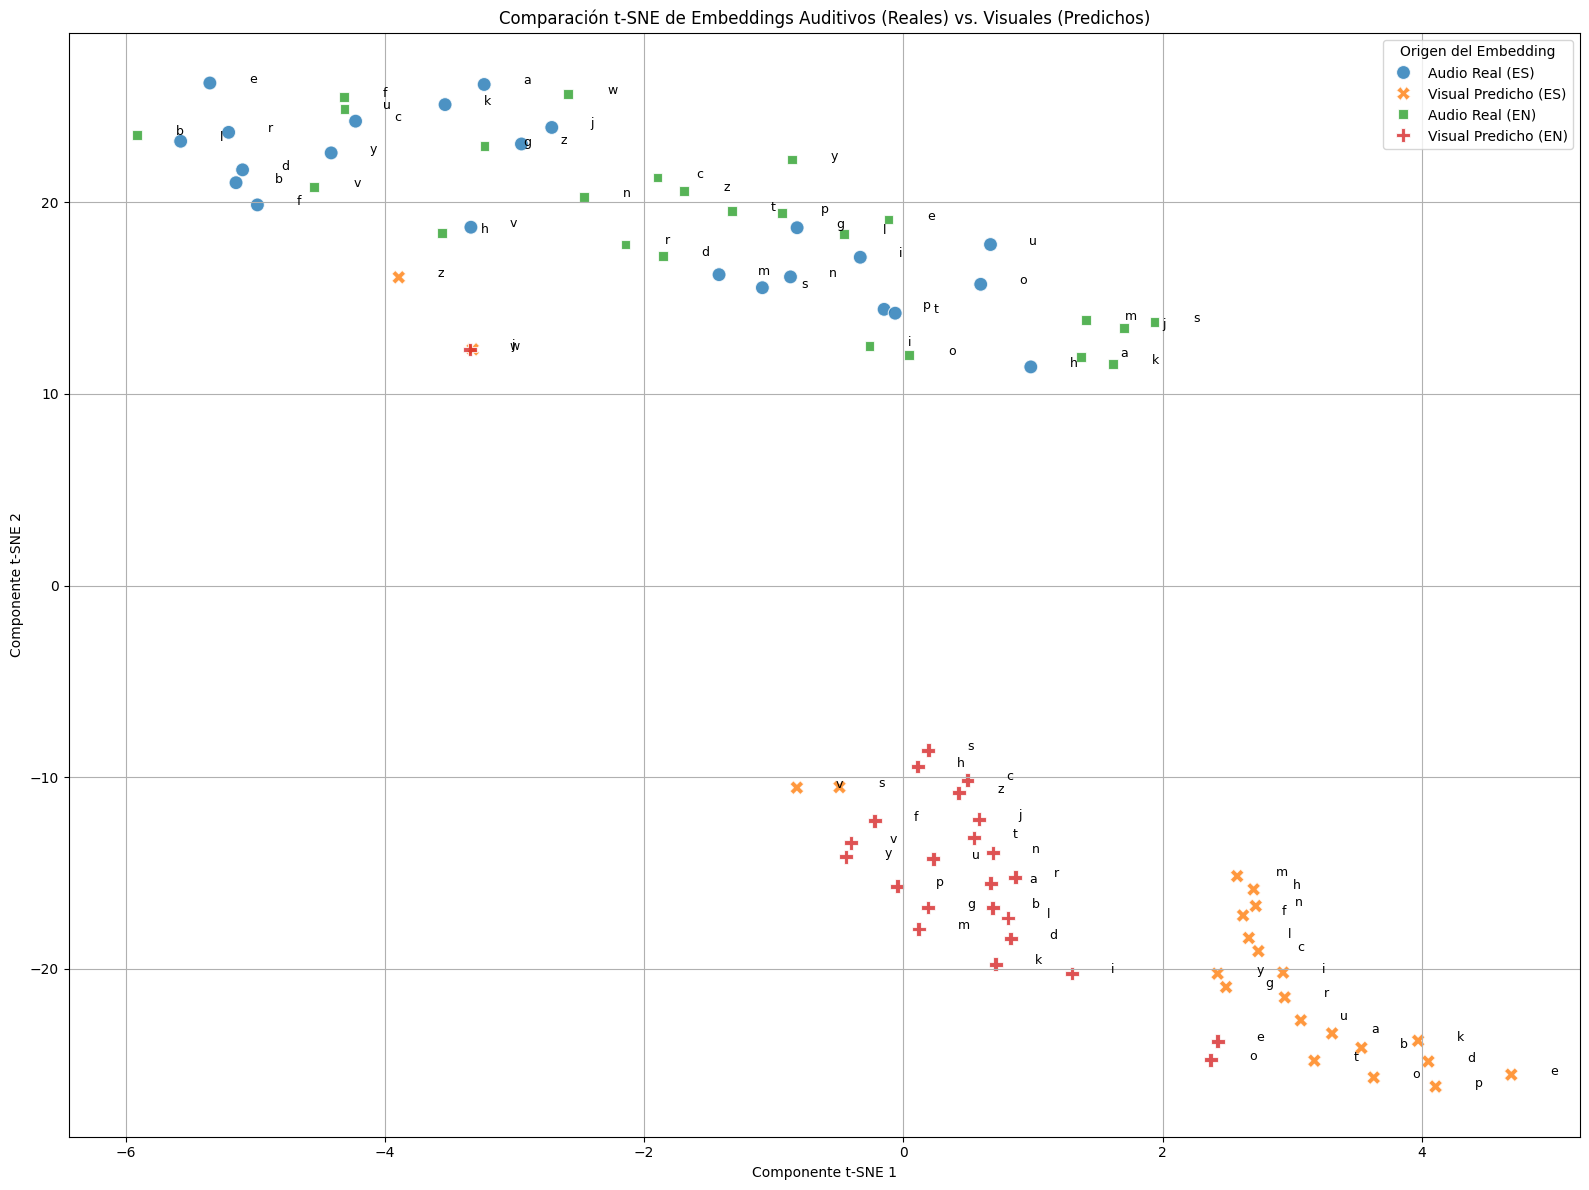

Gráfico t-SNE comparativo guardado en: /home/daniel/Proyectos/phonological-awareness/results/figures/auditory_vs_visual_tsne_comparison.png


In [7]:
from sklearn.manifold import TSNE

# --- Preparar datos para el gráfico fusionado ---
all_embeddings_avg = []
all_labels = []
all_sources = []

print("Preparando datos para la visualización t-SNE comparativa...")

for lang in LANGUAGES:
    # --- 1. Cargar embeddings REALES de la vía auditiva y promediarlos ---
    audio_embedding_dir = project_root / f"data/02_processed/wav2vec2_embeddings/{lang}"
    # Obtenemos solo los grafemas comunes que se usaron en el entrenamiento visual
    visual_dataset = GraphemeDataset(
        project_root / f"data/02_processed/grapheme_images/{lang}",
        audio_embedding_dir
    )
    # Creamos un set de los grafemas para una búsqueda rápida
    common_graphemes = {p.parent.name for p in visual_dataset.image_paths}
    
    for label in sorted(list(common_graphemes)):
        embedding_seq = np.load(audio_embedding_dir / f"{label}.npy")
        all_embeddings_avg.append(embedding_seq.mean(axis=0))
        all_labels.append(label)
        all_sources.append(f'Audio Real ({lang.upper()})')
        
    # --- 2. Generar embeddings PREDICHOS de la vía visual y promediarlos ---
    visual_model = results_visual[lang]['model']
    visual_model.eval()
    
    # Usamos el dataset de validación para generar las predicciones
    val_dataset_lang = results_visual[lang]['val_dataset']
    val_loader_lang = DataLoader(val_dataset_lang, batch_size=BATCH_SIZE, collate_fn=collate_fn_visual)
    
    # Diccionario para agrupar predicciones por etiqueta
    predictions_by_label = {label: [] for label in common_graphemes}

    with torch.no_grad():
        for i, (images, target_embeddings) in enumerate(val_loader_lang):
            # Para obtener la etiqueta, necesitamos acceder al dataset original
            start_idx = i * BATCH_SIZE
            batch_labels = [val_dataset_lang.dataset.image_paths[idx].parent.name for idx in val_dataset_lang.indices[start_idx:start_idx+len(images)]]

            predicted_seqs = visual_model(images.to(device), target_embeddings.to(device))
            predicted_avg = predicted_seqs.mean(dim=1).cpu().numpy()
            
            for j, label in enumerate(batch_labels):
                predictions_by_label[label].append(predicted_avg[j])

    # Promediar las predicciones para cada grafema
    for label in sorted(list(common_graphemes)):
        if predictions_by_label[label]:
            avg_pred = np.mean(predictions_by_label[label], axis=0)
            all_embeddings_avg.append(avg_pred)
            all_labels.append(label)
            all_sources.append(f'Visual Predicho ({lang.upper()})')

# --- Calcular y Graficar t-SNE ---
embedding_matrix_combined = np.array(all_embeddings_avg)
print("\nCalculando proyección t-SNE para todos los embeddings... Esto puede tardar.")
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='pca', learning_rate='auto')
embeddings_2d = tsne.fit_transform(embedding_matrix_combined)

tsne_df = pd.DataFrame({
    'tsne-1': embeddings_2d[:, 0],
    'tsne-2': embeddings_2d[:, 1],
    'grapheme': all_labels,
    'source': all_sources
})

# --- Graficar ---
plt.figure(figsize=(16, 12))
sns.scatterplot(
    x="tsne-1", y="tsne-2",
    hue="source",
    style="source",
    data=tsne_df,
    s=100, # Tamaño de los puntos
    alpha=0.8
)

# Añadir anotaciones para identificar los grafemas
for i, row in tsne_df.iterrows():
    plt.text(row['tsne-1']+0.3, row['tsne-2'], row['grapheme'], fontsize=9)

plt.title('Comparación t-SNE de Embeddings Auditivos (Reales) vs. Visuales (Predichos)')
plt.xlabel('Componente t-SNE 1'); plt.ylabel('Componente t-SNE 2'); plt.grid(True)
plt.legend(title='Origen del Embedding')
plt.tight_layout()

# Guardar la figura final
tsne_comparison_path = figure_dir / "auditory_vs_visual_tsne_comparison.png"
plt.savefig(tsne_comparison_path)
plt.show()

print(f"Gráfico t-SNE comparativo guardado en: {tsne_comparison_path}")

## Paso 4: Evaluación Comparativa Final (Vía Visual vs. Vía Auditiva)

Este es el experimento culminante del proyecto. Comparamos directamente el rendimiento del **clasificador auditivo** bajo dos condiciones:
1.  **Condición Auditiva (Original)**: Cuando recibe como entrada los embeddings reales extraídos del audio.
2.  **Condición Visual (Cruzada)**: Cuando recibe como entrada los embeddings "imaginados" que nuestro modelo visual predijo a partir de imágenes.

Analizamos esta comparación a través de dos métricas clave:
-   **Matriz de Confusión**: Muestra las decisiones finales de clasificación (aciertos y errores).
-   **Heatmap de Logits**: Muestra la "confianza" o la puntuación que el clasificador asigna a cada posible fonema antes de tomar la decisión final.

Una alta similitud entre las matrices y los heatmaps de ambas vías indicaría que nuestro modelo visual ha aprendido a generar representaciones auditivas de alta fidelidad.


--- Evaluación Comparativa para: ES ---


ValueError: not enough values to unpack (expected 3, got 2)

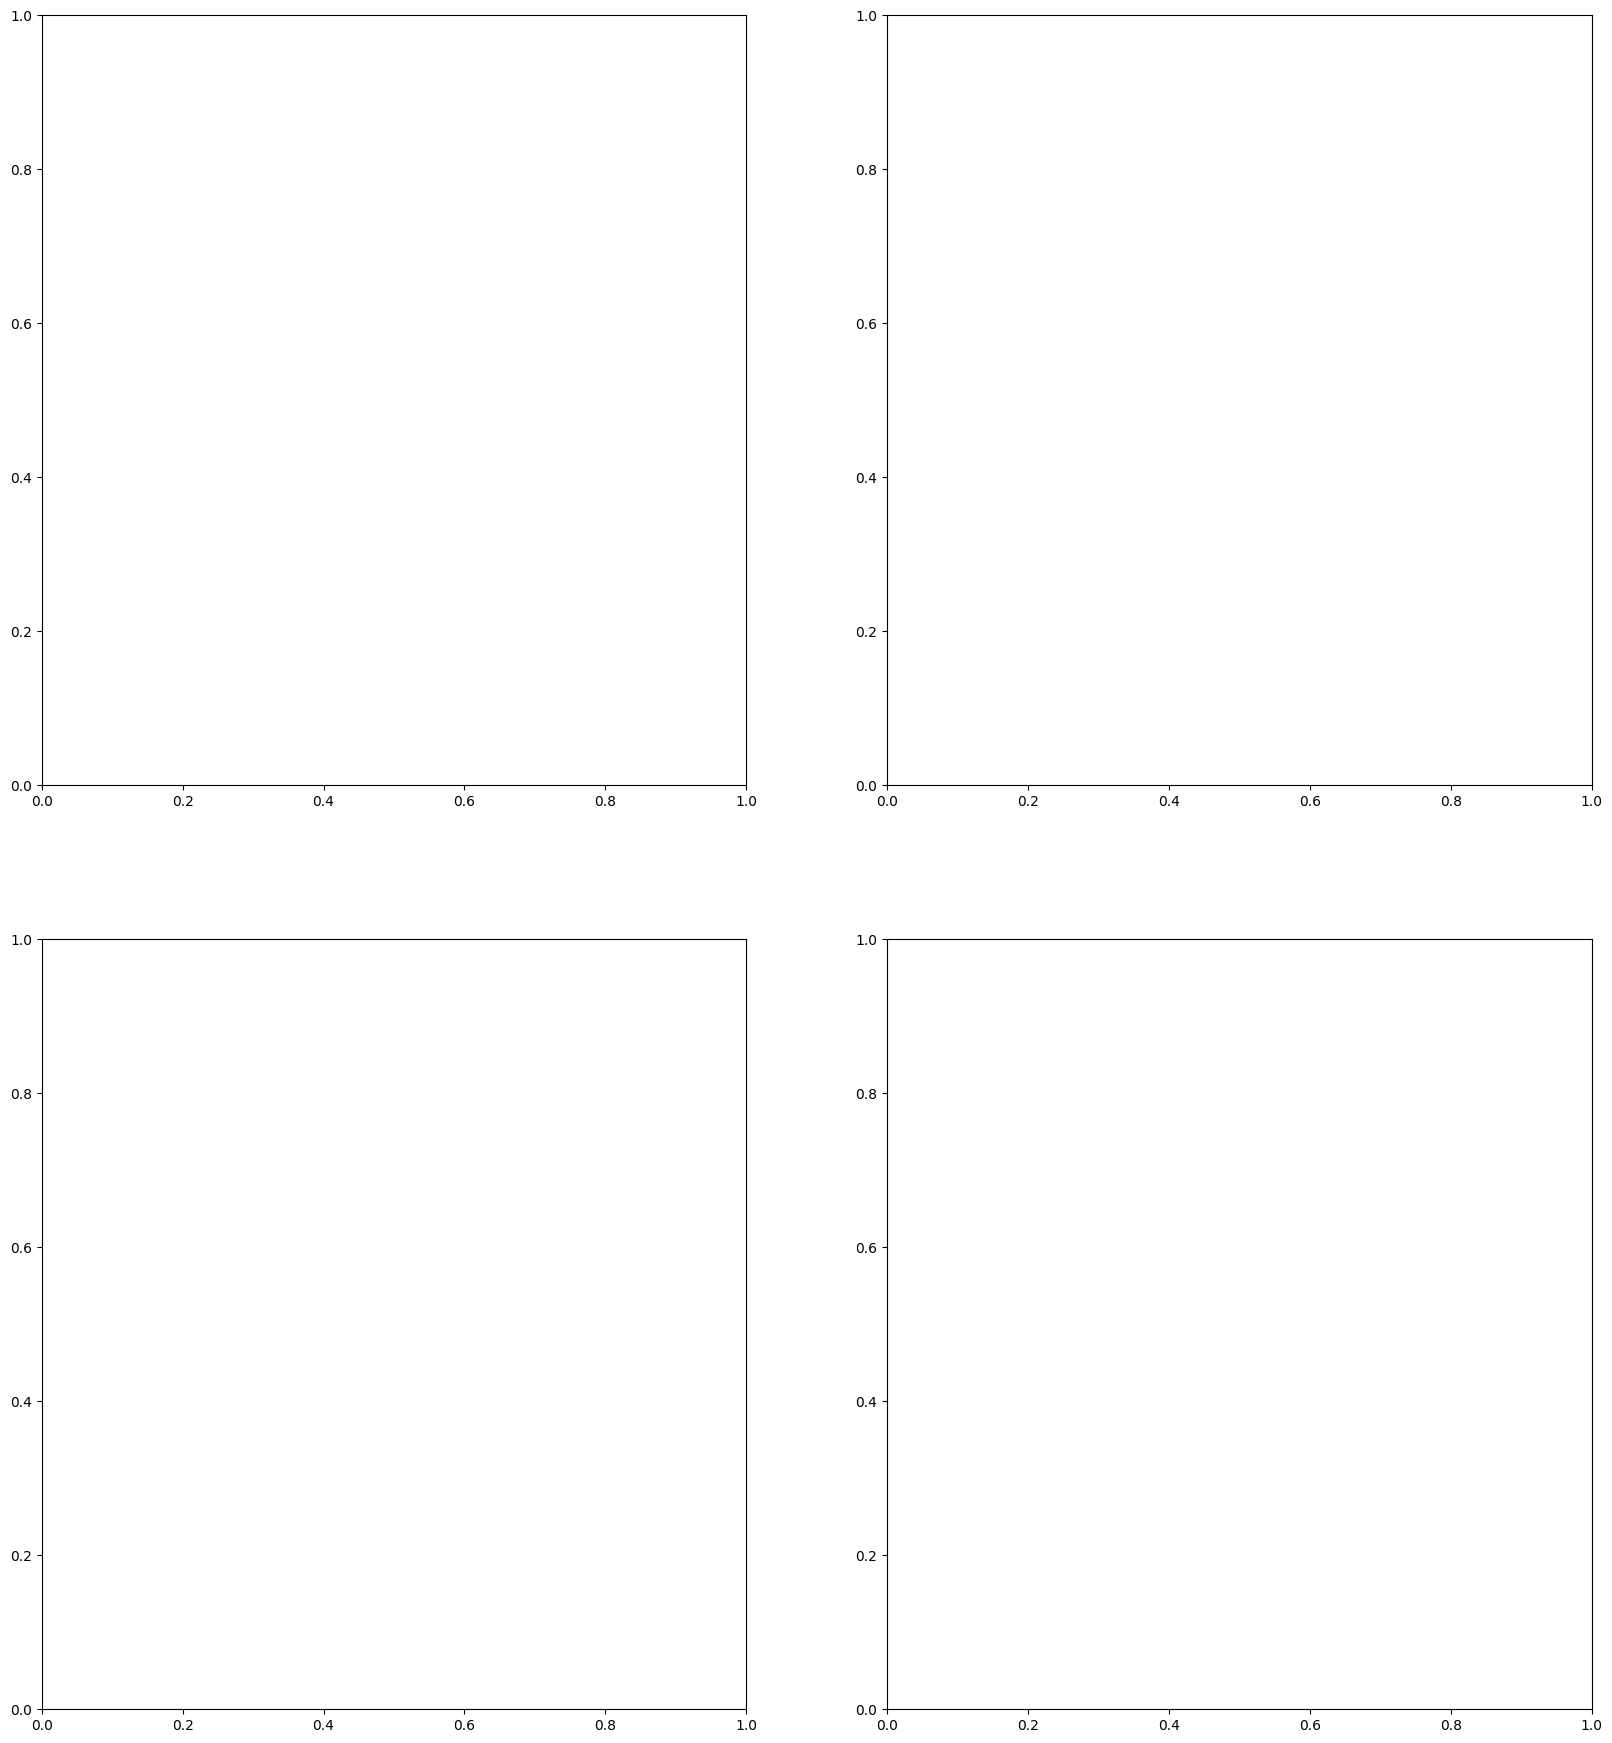

In [ ]:
# --- Importaciones necesarias para la evaluación ---
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def collate_fn_visual_with_labels(batch):
    images = [item[0] for item in batch]
    embeddings = [item[1] for item in batch]
    labels = [item[2] for item in batch]
    images_tensor = torch.stack(images)
    padded_embeddings = pad_sequence(embeddings, batch_first=True, padding_value=0.0)
    return images_tensor, padded_embeddings, labels

# --- Bucle de Evaluación y Visualización Comparativa ---
# Creamos una figura con 2 filas (para CM y Logits) y tantas columnas como idiomas
fig, axes = plt.subplots(2, len(LANGUAGES), figsize=(20, 22))
if len(LANGUAGES) == 1: axes = axes.reshape(2, 1)

for i, lang in enumerate(LANGUAGES):
    print(f"\n--- Evaluación Comparativa para: {lang.upper()} ---")
    
    # --- 1. Cargar el Clasificador Auditivo Entrenado (de NB02) ---
    auditory_model_path = model_dir / f"{lang}_auditory_cnn1d_comparative.pth"
    if not auditory_model_path.exists():
        for row in range(2): axes[row, i].text(0.5, 0.5, f"Modelo auditivo para '{lang}' no encontrado.", ha='center')
        continue
        
    audio_embedding_dir = project_root / f"data/02_processed/wav2vec2_embeddings/{lang}"
    auditory_labels = sorted([p.stem for p in audio_embedding_dir.glob("*.npy")])
    num_auditory_classes = len(auditory_labels)
    auditory_label_to_int = {label: i for i, label in enumerate(auditory_labels)}

    auditory_cnn = PhonemeCNN(input_size=1024, num_classes=num_auditory_classes).to(device)
    auditory_cnn.load_state_dict(torch.load(auditory_model_path, map_location=device))
    auditory_cnn.eval()

    # --- 2. Generar Predicciones y Logits de la VÍA VISUAL (Cruzada) ---
    visual_model = results_visual[lang]['model']
    visual_model.eval()
    
    # Usamos el DataLoader de validación de la vía visual
    val_loader_lang = results_visual[lang]['val_dataset']
    # (Asegúrate de que 'GraphemeDataset' y 'collate_fn_visual_with_labels' estén definidos como en la respuesta anterior)
    
    true_indices_cross = []
    pred_indices_cross = []
    logits_cross = []
    
    with torch.no_grad():
        for images, target_embeddings, true_labels_text in val_loader_lang:
            predicted_embeddings = visual_model(images.to(device), target_embeddings.to(device))
            outputs = auditory_cnn(predicted_embeddings)
            _, predicted_indices = torch.max(outputs.data, 1)
            
            # Guardar logits y predicciones
            logits_cross.append(outputs.cpu().numpy())
            pred_indices_cross.extend(predicted_indices.cpu().numpy())
            
            # Convertir etiquetas de texto a índices
            true_indices = torch.tensor([auditory_label_to_int.get(lbl) for lbl in true_labels_text if lbl in auditory_label_to_int], dtype=torch.long)
            true_indices_cross.extend(true_indices.numpy())
    
    logits_cross = np.vstack(logits_cross)

    # --- 3. Graficar Matriz de Confusión Cruzada ---
    ax_cm_cross = axes[0, i]
    cm_cross = confusion_matrix(true_indices_cross, pred_indices_cross, labels=range(len(auditory_labels)))
    disp_cross = ConfusionMatrixDisplay(confusion_matrix=cm_cross, display_labels=auditory_labels)
    disp_cross.plot(ax=ax_cm_cross, xticks_rotation='vertical', cmap='magma')
    ax_cm_cross.set_title(f'VÍA VISUAL (Cruzada) - {lang.upper()}')

    # --- 4. Graficar Heatmap de Logits Cruzado ---
    ax_logits_cross = axes[1, i]
    sns.heatmap(logits_cross, ax=ax_logits_cross, cmap='rocket', xticklabels=auditory_labels)
    ax_logits_cross.set_title(f'Logits VÍA VISUAL - {lang.upper()}')
    ax_logits_cross.set_xlabel('Clase Predicha (Logits)')
    ax_logits_cross.set_ylabel('Muestra de Entrada (Orden de Dataloader)')


# Añadimos títulos generales a las filas para mayor claridad
axes[0, 0].set_ylabel('Etiqueta Verdadera', fontsize=14, weight='bold')
axes[1, 0].set_ylabel('Muestra de Entrada', fontsize=14, weight='bold')

fig.suptitle('Comparación Final de Vías: Matriz de Confusión y Logits', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()